In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [3]:
imgs = list(sorted(os.listdir("face mask detection/images/")))
print(imgs)

['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png', 'maksssksksss100.png', 'maksssksksss101.png', 'maksssksksss102.png', 'maksssksksss103.png', 'maksssksksss104.png', 'maksssksksss105.png', 'maksssksksss106.png', 'maksssksksss107.png', 'maksssksksss108.png', 'maksssksksss109.png', 'maksssksksss11.png', 'maksssksksss110.png', 'maksssksksss111.png', 'maksssksksss112.png', 'maksssksksss113.png', 'maksssksksss114.png', 'maksssksksss115.png', 'maksssksksss116.png', 'maksssksksss117.png', 'maksssksksss118.png', 'maksssksksss119.png', 'maksssksksss12.png', 'maksssksksss120.png', 'maksssksksss121.png', 'maksssksksss122.png', 'maksssksksss123.png', 'maksssksksss124.png', 'maksssksksss125.png', 'maksssksksss126.png', 'maksssksksss127.png', 'maksssksksss128.png', 'maksssksksss129.png', 'maksssksksss13.png', 'maksssksksss130.png', 'maksssksksss131.png', 'maksssksksss132.png', 'maksssksksss133.png', 'maksssksksss134.png', 'maksssksksss135.png', 'maksssksksss136.png', 'maksssksksss137.p

In [4]:
labels = list(sorted(os.listdir("face mask detection/annotations/")))
print(labels)

['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml', 'maksssksksss100.xml', 'maksssksksss101.xml', 'maksssksksss102.xml', 'maksssksksss103.xml', 'maksssksksss104.xml', 'maksssksksss105.xml', 'maksssksksss106.xml', 'maksssksksss107.xml', 'maksssksksss108.xml', 'maksssksksss109.xml', 'maksssksksss11.xml', 'maksssksksss110.xml', 'maksssksksss111.xml', 'maksssksksss112.xml', 'maksssksksss113.xml', 'maksssksksss114.xml', 'maksssksksss115.xml', 'maksssksksss116.xml', 'maksssksksss117.xml', 'maksssksksss118.xml', 'maksssksksss119.xml', 'maksssksksss12.xml', 'maksssksksss120.xml', 'maksssksksss121.xml', 'maksssksksss122.xml', 'maksssksksss123.xml', 'maksssksksss124.xml', 'maksssksksss125.xml', 'maksssksksss126.xml', 'maksssksksss127.xml', 'maksssksksss128.xml', 'maksssksksss129.xml', 'maksssksksss13.xml', 'maksssksksss130.xml', 'maksssksksss131.xml', 'maksssksksss132.xml', 'maksssksksss133.xml', 'maksssksksss134.xml', 'maksssksksss135.xml', 'maksssksksss136.xml', 'maksssksksss137.x

In [5]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # Load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir("face mask detection/images/")))
        self.labels = list(sorted(os.listdir("face mask detection/annotations/")))

    def __len__(self):
        # Return the number of images
        return len(self.imgs)

    def __getitem__(self, idx):
        # Load images and masks
        img_name = self.imgs[idx]
        label_name = self.labels[idx]

        img_path = os.path.join("face mask detection/images/", img_name)
        label_path = os.path.join("face mask detection/annotations/", label_name)

        img = Image.open(img_path).convert("RGB")
        # Generate label
        target = generate_target(idx, label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target



In [6]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, collate_fn=collate_fn)

In [8]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
model = get_model_instance_segmentation(3)

C:\Users\Khushboo Mittal\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Khushboo Mittal\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'labels': tensor([0, 1, 0]), 'image_id': tensor([0])}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0]), 'image_id': tensor([1])}, {'boxes': tensor([[ 98., 267., 194., 383.]]), 'labels': tensor([1]), 'image_id': tensor([2])}, {'boxes': tensor([[189.,  30., 245.,  88.],
        [387.,  54., 400.,  75.],
        [118.,  87., 163., 126.]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([3])}]


In [11]:
num_epochs = 10
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} 
for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)
                       

Iteration: 1/214, Loss: 1.456829309463501
Iteration: 2/214, Loss: 0.8145971894264221
Iteration: 3/214, Loss: 1.038140892982483
Iteration: 4/214, Loss: 0.5161734223365784
Iteration: 5/214, Loss: 0.2933797836303711
Iteration: 6/214, Loss: 1.49797785282135
Iteration: 7/214, Loss: 1.2104979753494263
Iteration: 8/214, Loss: 0.6477160453796387
Iteration: 9/214, Loss: 0.35826998949050903
Iteration: 10/214, Loss: 0.8302985429763794
Iteration: 11/214, Loss: 0.7153420448303223
Iteration: 12/214, Loss: 0.6159294843673706
Iteration: 13/214, Loss: 0.3029341399669647
Iteration: 14/214, Loss: 0.4055030047893524
Iteration: 15/214, Loss: 0.9305509924888611
Iteration: 16/214, Loss: 1.069422721862793
Iteration: 17/214, Loss: 1.2341692447662354
Iteration: 18/214, Loss: 0.21004155278205872
Iteration: 19/214, Loss: 0.4910038113594055
Iteration: 20/214, Loss: 0.6392495036125183
Iteration: 21/214, Loss: 0.21910427510738373
Iteration: 22/214, Loss: 0.5723812580108643
Iteration: 23/214, Loss: 0.2252241671085357

In [12]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [32]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
        box1 (list): [xmin, ymin, xmax, ymax]
        box2 (list): [xmin, ymin, xmax, ymax]
    
    Returns:
        float: IoU value
    """
    # Calculate intersection
    x_min_inter = max(box1[0], box2[0])
    y_min_inter = max(box1[1], box2[1])
    x_max_inter = min(box1[2], box2[2])
    y_max_inter = min(box1[3], box2[3])
    
    inter_area = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)
    
    # Calculate areas of the two bounding boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Calculate union area
    union_area = box1_area + box2_area - inter_area
    
    # Return IoU
    return inter_area / union_area if union_area > 0 else 0


In [33]:
def evaluate_predictions(preds, targets, iou_threshold=0.5):
    """
    Evaluate the model predictions using precision and recall.
    
    Parameters:
        preds (list): List of predictions, each containing 'boxes' and 'labels'
        targets (list): List of ground truth annotations, each containing 'boxes' and 'labels'
        iou_threshold (float): IoU threshold to determine true positives
    
    Returns:
        dict: Evaluation metrics including precision, recall, and IoU
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    ious = []
    
    for pred, target in zip(preds, targets):
        pred_boxes = pred['boxes'].detach().cpu().numpy()
        pred_labels = pred['labels'].detach().cpu().numpy()
        
        target_boxes = target['boxes'].cpu().numpy()
        target_labels = target['labels'].cpu().numpy()
        
        matched = set()  # Track matched ground truth boxes
        
        for i, pred_box in enumerate(pred_boxes):
            best_iou = 0
            best_gt_idx = -1
            
            for j, target_box in enumerate(target_boxes):
                iou = calculate_iou(pred_box, target_box)
                if iou > best_iou and j not in matched:
                    best_iou = iou
                    best_gt_idx = j
            
            if best_iou >= iou_threshold and pred_labels[i] == target_labels[best_gt_idx]:
                true_positives += 1
                matched.add(best_gt_idx)
                ious.append(best_iou)
            else:
                false_positives += 1
        
        false_negatives += len(target_boxes) - len(matched)
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    mean_iou = np.mean(ious) if ious else 0
    
    return {"precision": precision, "recall": recall, "mean_iou": mean_iou}


In [34]:
# Evaluate model on test data
model.eval()
with torch.no_grad():
    preds = model(imgs)  # Predictions

# Call evaluation function
metrics = evaluate_predictions(preds, annotations)
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Mean IoU: {metrics['mean_iou']:.4f}")


Precision: 0.8571
Recall: 0.7500
Mean IoU: 0.8020


In [35]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# Class label mapping
class_mapping = {0: "Without Mask", 1: "With Mask", 2: "Mask Worn Incorrectly"}

def plot_image(image, prediction):
    # Convert image tensor to a NumPy array
    if torch.is_tensor(image):
        image = image.detach().cpu().numpy().transpose(1, 2, 0)  # Convert to (H, W, C)
    
    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot bounding boxes
    boxes = prediction['boxes'].detach().cpu().numpy()  # Detach boxes from computation graph
    labels = prediction['labels'].detach().cpu().numpy()  # Detach labels from computation graph

    # Plot each box with class names
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Get the class name from the mapping
        class_name = class_mapping.get(labels[i], "Unknown Class")
        
        # Display the class name above the bounding box
        ax.text(xmin, ymin, class_name, color='blue', fontsize=12)
    
    plt.show()



Prediction


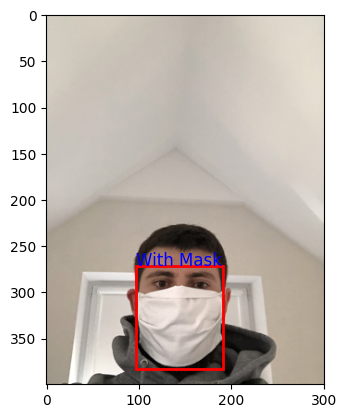

Target


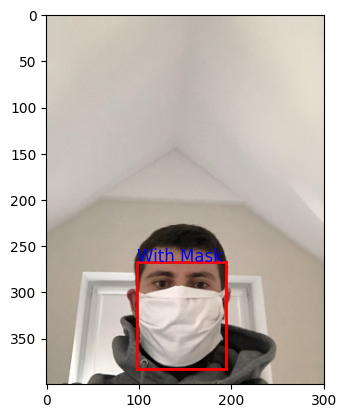

Precision: 0.8571
Recall: 0.7500
Mean IoU: 0.8020


In [36]:
print("Prediction")
plot_image(imgs[2], preds[2])

print("Target")
plot_image(imgs[2], annotations[2])

# Evaluate the predictions
metrics = evaluate_predictions(preds, annotations)
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Mean IoU: {metrics['mean_iou']:.4f}")

In [26]:
torch.save(model.state_dict(),'model.pt')

In [27]:
model2 = get_model_instance_segmentation(3)

In [28]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

C:\Users\Khushboo Mittal\AppData\Local\Temp\ipykernel_22380\2114896388.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('model.pt'))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [29]:
pred2 = model2(imgs)

Predict with loaded model


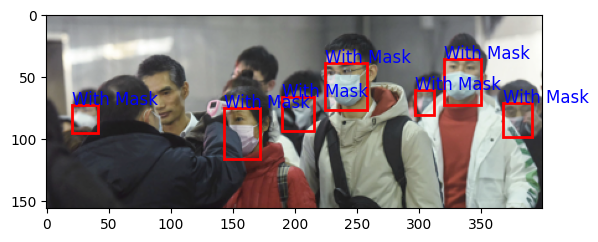

In [44]:
print("Predict with loaded model")
plot_image(imgs[1], pred2[1])